In [14]:
from functions import *

In [15]:
params = read_parameters()
file_idx = params['file_idx']
tmp_idx = params['tmp_idx']
x_axis = params['x_axis']
x_format = X_AXIS_FORMAT[x_axis]
use_default_arima_params = params['use_default_arima_params']
default_arima_params = params['default_arima_params']
include_arima_simulations_in_analysis = params['include_arima_simulations_in_analysis']
# always exclude outliers here
include_outliers = False

parameters:
x_axis: time [m]
file_idx_uppaal: 1
file_idx: 1
tmp_idx: 0
log: True
plot_scatterplot_matrix: False
use_default_arima_params: True
default_arima_params: [1, 1, 0]
include_arima_simulations_in_analysis: True
include_outliers: True
mark_outliers: True


In [16]:
in_folder = PATH_SENSORS_DATA_EXT_UF_V1
cur_file, file_path = get_input_file(in_folder=in_folder, in_file_idx=file_idx, log=True)
out_file = FILE_SENSORS_DATA_EST_PARAMS

file list:
0 /app/data/from_sensors/1_extended/UF/v1/2024-07-11 tap water - reflux valve closed.csv
1 /app/data/from_sensors/1_extended/UF/v1/2024-07-12 tap water - reflux valve open.csv
2 /app/data/from_sensors/1_extended/UF/v1/2024-07-15 wastewater 0.500 gL - reflux valve open.csv
3 /app/data/from_sensors/1_extended/UF/v1/2024-07-16 wastewater 0.125 gL - reflux valve open.csv
4 /app/data/from_sensors/1_extended/UF/v1/2024-07-16 wastewater 0.250 gL - reflux valve open.csv

input file:
/app/data/from_sensors/1_extended/UF/v1/2024-07-12 tap water - reflux valve open.csv


In [17]:
FLUX_COL = 'flux at 20° [L/m^2h]' #'flux [L/m^2h]'
FLUX_USED = FLUX_COL[:-9]
print(FLUX_USED)

flux at 20°


In [18]:
df_bckup = None
df = pd.read_csv(file_path)
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df = identify_all_outliers(df, drop_outliers=(not include_outliers), log=True)
df = identify_TMP_groups(
    df, series_col='TMP [kPa]', group_col='TMP group', drop_outliers=(not include_outliers), log=True,
    max_distance_from_average=MAX_DISTANCE_FROM_TMP_AVERAGE, min_size=MIN_OBSERVATIONS_PER_TMP_GROUP)
df = add_cross_flow_velocity_and_estimated_retentate_flow(df, cur_file)
df = add_estimate_retentate_pressure(
    df, target_col='prs retentate [kPa]', group_by_cols=['TMP group'])

found 1 new outliers after checking column is_ON by function identify_outliers__machine_OFF
 - total number of outliers: 0 -> 1
found 6 new outliers after checking column res tot [1/m] by function identify_outliers__far_median
 - total number of outliers: 1 -> 7
found 1 new outliers after checking column prs feed_2 [kPa] by function identify_outliers__far_neighbours
 - total number of outliers: 7 -> 8
dropped all outliers.
 - total number of outliers: 8 -> 0
added column: 'TMP group', computed by checking if the current point is near the moving average of the previous points (max_distance_from_average=12.5)
found 3 new outliers after checking column TMP group by function identify_outliers__nan_column
 - total number of outliers: 0 -> 3
dropped all outliers.
 - total number of outliers: 3 -> 0
added column: 'vlct crsflow [m/s]', estimated using a formula based on membranes data and feed flow
added column: 'flow retentate est by vlct crsflow [L/h]', estimated by using a formula based on 

/app/src/functions.py:497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'abs({c})'] = abs(df[c])
/app/src/functions.py:498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['to_drop'] = df[f'abs({c})'].apply(lambda x : (max(x, median) / min(x, median)) > max_ratio)
/app/src/functions.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [19]:
try:
    # already created
    df_k_n = pd.read_csv(FILE_SENSORS_DATA_EST_PARAMS)
except:
    # to be created yet
    df_k_n = pd.DataFrame()

In [20]:
print(df.loc[0, ['initial feed concentration [g/L]']])

initial feed concentration [g/L]    0.0
Name: 0, dtype: object


(<Axes: xlabel='time [m]', ylabel='flux [LMH]'>,
 <Axes: title={'center': 'Flux and res over Time'}, ylabel='res tot [1/m]'>)

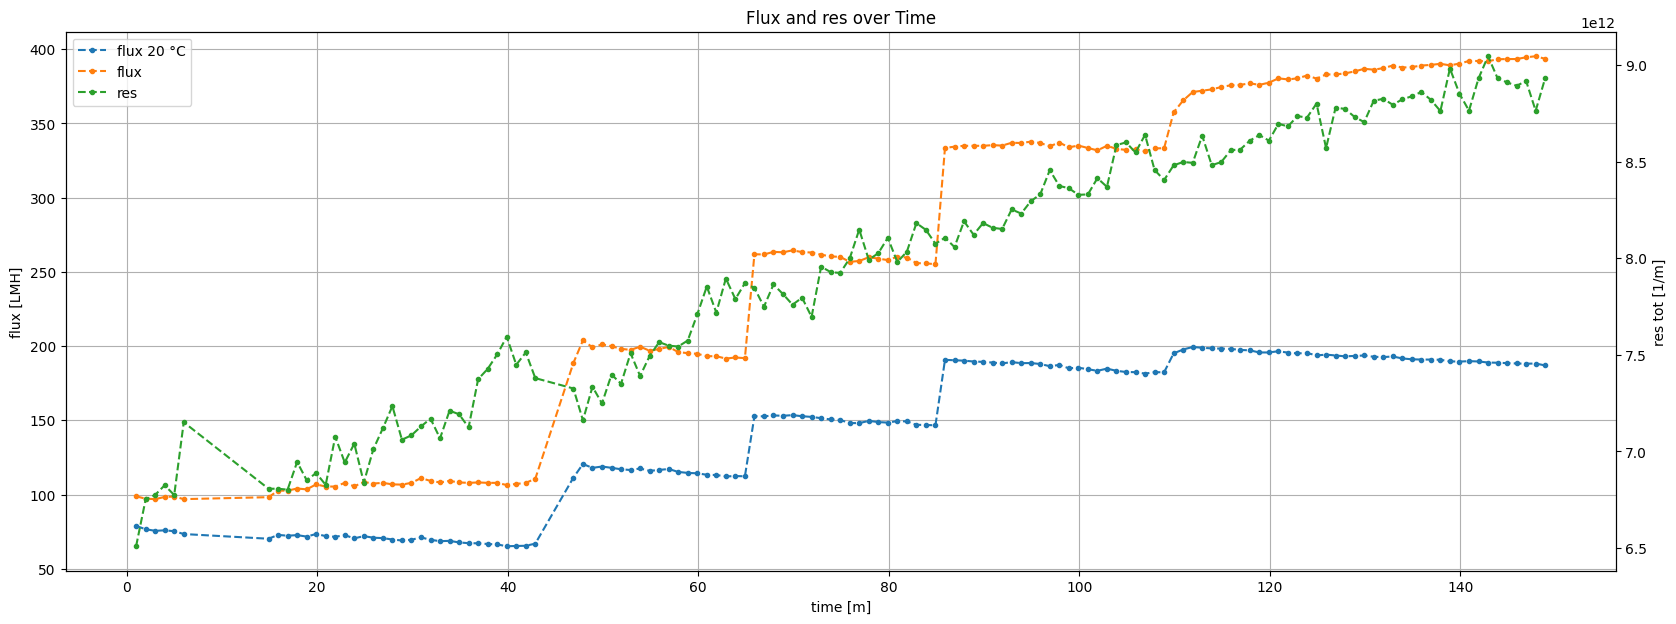

In [21]:
y_dict = {
    'flux 20 °C' : df['flux at 20° [L/m^2h]'],
    'flux' : df['flux [L/m^2h]'],
    'res'  : df['res tot [1/m]'],
}
y_ax_lbl = ['flux [LMH]', 'res tot [1/m]']
title    = 'Flux and res over Time'
plot_time_series_2_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, 
    title=title, x_format=x_format, secondary_y=['res'], loc='upper left')

(<Axes: xlabel='time [m]', ylabel='flux [LMH]'>,
 <Axes: title={'center': 'Flux and TMP over Time'}, ylabel='TMP [kPa]'>)

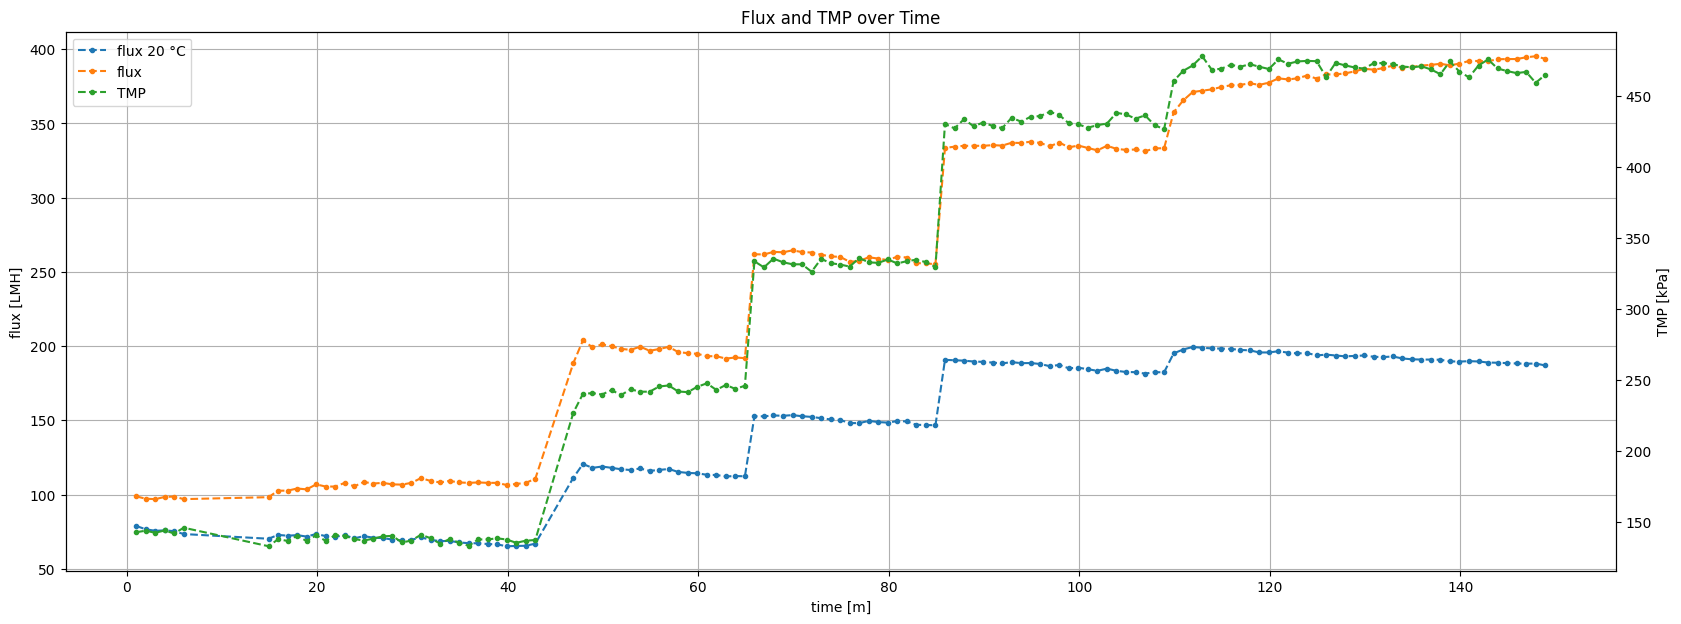

In [22]:
y_dict = {
    'flux 20 °C' : df['flux at 20° [L/m^2h]'],
    'flux' : df['flux [L/m^2h]'],
    'TMP'  : df['TMP [kPa]'],
}
y_ax_lbl = ['flux [LMH]', 'TMP [kPa]']
title    = 'Flux and TMP over Time'
plot_time_series_2_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, 
    title=title, x_format=x_format, secondary_y=['TMP'], loc='upper left')

In [23]:
df = df[df['TMP group'] == tmp_idx].reset_index(drop=True)
# reset time so it starts from 0
df['time [m]'] = change_col_offset(df, 'time [m]')

In [25]:
# add estimated columns
PRS_RETENTATE_EST_kPa = df['prs retentate [kPa]'].median()
df['prs retentate est [kPa]'] = PRS_RETENTATE_EST_kPa
estimated_columns = ["prs feed_1 [kPa]", "prs feed_2 [kPa]", "prs permeate [kPa]", "flow retentate [L/h]"]
for c in estimated_columns:
    c_est = re.sub(r'(\[.*\])$', r'est \1', c)
    print(c_est)
    model = read_estimated_coefficients_from_json(FILE_EST_COEFFS, c)
    cols = model['x']
    if cols == None :
        df[c_est] = model['intercept']
    else :
        df[c_est] = predict_y(df[model['x']], model['intercept'], model['coefficients']) 

prs feed_1 est [kPa]


FileNotFoundError: [Errno 2] No such file or directory: '/app/output/estimated_coefficients/estimated_coefficients.json'

In [ ]:
df['TMP est [kPa]'] = 0.5 * (df['prs retentate est [kPa]'] + df['prs feed_2 est [kPa]']) - df['prs permeate est [kPa]']
PRS_TMP_EST_kPA = df.loc[0,'TMP est [kPa]']
PRS_PRMT_EST_kPA = df.loc[0,'prs permeate est [kPa]']
print("estimated TMP:", PRS_TMP_EST_kPA)

In [ ]:
df = add_TMP_levels(df, col='TMP est [kPa]')
TMP_LVL_COLS = [ c for c in df.columns if c[:9] == 'is TMP in']
print(TMP_LVL_COLS)
df[:2][ ['TMP est [kPa]'] + TMP_LVL_COLS ]

In [ ]:
df['res tot [%]'] = min_max_scaler(df['res tot [1/m]'])
df['TMP [%]'] = min_max_scaler(df['TMP [kPa]'])
df['viscosity permeate [%]'] = min_max_scaler(df['viscosity permeate [Pa s]'])
df['prs permeate [%]'] = min_max_scaler(df['prs permeate [kPa]'])
y_dict = {
    'flux 20 °C' : df['flux at 20° [L/m^2h]'],
    'flux' : df['flux [L/m^2h]'],
    'res'  : df['res tot [%]'],
    'TMP'  : df['TMP [%]'],
    'viscosity' : df['viscosity permeate [%]'],
    #'prs permeate [%]' : df['prs permeate [%]']
}
print(df.agg({
    'flux at 20° [L/m^2h]'          : ["min", "median", "mean",  "max", "std", "var"],
    'flux [L/m^2h]'                 : ["min", "median", "mean",  "max", "std", "var"],
    "res tot [1/m]"                 : ["min", "median", "mean",  "max", "std", "var"],
    "TMP [kPa]"                     : ["min", "median", "mean",  "max", "std", "var"],
    "viscosity permeate [Pa s]"     : ["min", "median", "mean",  "max", "std", "var"],
    #"prs permeate [kPa]"            : ["min", "median", "mean",  "max", "std", "var"],
}))

y_ax_lbl = ['flux [LMH]', 'factor [%]']
title    = 'Flux vs its factors over time'
#plot_time_series_1_axis(x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, title=title, x_format=x_format)
plot_time_series_2_axis(x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, title=title, x_format=x_format, secondary_y=['res', 'TMP', 'viscosity'], loc='upper center')

In [ ]:
if df_bckup is not None :
    df = df_bckup

In [ ]:
print(FLUX_COL)
#df[['flux at 20° [L/m^2h]', 'flux [L/m^2h]']]

In [ ]:
# ACF  plot: autocorrelations which measure the relationship between y_t and y_{t-k} for k >= 1
# PACF plot: autocorrelations which measure the relationship between y_t and y_{t-k} for k >= 1 AFTER removing the effects of i=1,...,k-1
# max_lags < n/2

In [ ]:
#If the data are from an ARIMA(p, d, 0) or ARIMA(0, d, q) model, then the ACF and PACF plots can be helpful in determining the value of p or q.
#If p and q are both positive, then the plots do not help in finding suitable values of p and q.
#The data may follow an ARIMA(p, d, 0) model if the ACF and PACF plots of the differenced data show the following patterns:
# - the ACF is exponentially decaying or sinusoidal;
# - there is a significant spike at lag p in the PACF, but none beyond lag p

In [ ]:
df_train = df[FLUX_COL]
adf_test, is_significant = check_stationarity(df_train, lags='default')

In [ ]:
differencing = True if use_default_arima_params else (not is_significant)

if not differencing :
    print("NOT differencing")
else :
    ok = False
    df_train_diff = df_train
    d = 0
    while not ok and d <= 0:
        d += 1
        print(f"differencing d={d}")
        df_train_diff = df_train_diff.diff().dropna()
        adf_test, ok = check_stationarity(df_train_diff, lags='default', show_plots=True)
        print()

In [ ]:
d = d if differencing else 0
print(f"d: {d}")
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False, trace=True, information_criterion='hqic', d=d)
(p,d,q) = auto_arima.get_params()['order']

In [ ]:
if use_default_arima_params :
    # override auto_arima best choice
    (p,d,q) = default_arima_params
print((p,d,q))

In [ ]:
model = arima.ARIMA(df_train, order=(p,d,q))
model_fit = model.fit()
model_fit.summary()

In [ ]:
forecast = model_fit.forecast(1000)
print(forecast[-5:])

In [ ]:
#df0 = df[[x_axis, FLUX_COL]][:5]
#df0['f(time [m])'] = df0[x_axis].apply(lambda x : x**(1/3)) #x**(0.35))
#display(df0[:5])
#model00, y_pred00, intercept00, coeffs00 = call_linear_model(df0[['f(time [m])']], df0[FLUX_COL], summary=True)

In [ ]:
### FOUND PARAMETERS !!!!!!!!!!!!
#J_0  = intercept00
J_Re = list(forecast)[-1]
#print(f"J_0  = {J_0:>.5f}")
print(f"J_Re = {J_Re:>.5f}")

In [ ]:
MAX_N = 50
n_periods = max(0, MAX_N - len(df))
# n_periods = 200
x_forecast = range(len(df)+1,n_periods+len(df)+1)
y_forecast = forecast[:n_periods]

up_to = min(10, max(5, len(df)//2))
flux_all = pd.concat([df[FLUX_COL], pd.Series(y_forecast[:up_to])]).reset_index(drop=True) #pd.Series(J_0), 
time_all = list(range(len(flux_all)))
pct = 0.6
flux_all_smooth = smooth_data_lowess(time_all, flux_all, pct=pct)
print(f"pct: {pct}, number of forecasted points used for smoothing: {up_to}")
compute_error_metrics(flux_all_smooth, flux_all)

plot_time_series_1_axis(x=time_all,              y_series={f"flux smoothed {pct}" : flux_all_smooth}, x_ax_lbl=x_axis, y_ax_lbl=FLUX_COL, title=None, x_format=x_format, color="yellow", figsize=(16,9))
# plot_time_series_1_axis(x=[0],                  y_series={"flux in t=0" : [J_0]},                  x_ax_lbl=x_axis, y_ax_lbl=FLUX_COL, title=None, x_format=x_format, color="green", figsize=None)
plot_time_series_1_axis(x=df[x_axis], y_series={'flux real' : df[FLUX_COL]},             x_ax_lbl=x_axis, y_ax_lbl=FLUX_COL, title=None, x_format=x_format, color="blue", figsize=None)
plot_time_series_1_axis(x=x_forecast,           y_series={'flux forecast': y_forecast},            x_ax_lbl=x_axis, y_ax_lbl=FLUX_COL, title='Flux forecast', x_format=x_format, color='red', figsize=None)
last_t = df.loc[len(df)-1,'time [m]']
plot.plot([last_t,last_t+1], [df.loc[len(df)-1,FLUX_COL], list(forecast)[0]], linestyle='--', color='red')
# plot.plot([0,1], [J_0,df.loc[0, FLUX_COL]], linestyle='--', color='green')
plot.axhline(J_Re, label='flux asymptote', linestyle='--', color='black')
plot.grid()
plot.legend()
plot.show()

In [ ]:
model_vis, y_pred_vis, intercept_vis, coeffs_vis = call_linear_model(df[['time [m]']], df['viscosity permeate [Pa s]'], summary=True)
y_dict = {
    'y real'  : df['viscosity permeate [Pa s]'],
    'y pred'  : y_pred_vis,
}
plot_time_series_1_axis(x=df[x_axis[0]], y_series=y_dict, x_ax_lbl=x_axis[0], y_ax_lbl='viscosity [Pa s]', title='viscosity linear prediction', x_format=x_format[0])

In [ ]:
# since the real concentrations are known only in t=0 of the first TMP (for the others is NaN)
# in the following TMP used the real concentration will be unknown
# so we use the estimated concentration as the initial one
# NB for the first TMP: conc_real = conc_est
#df['retentate concentration [g/L]'] = df['retentate concentration est [g/L] v2']
#df['permeate concentration [g/L]']  = df['permeate concentration est [g/L] v2']

In [ ]:
#####################################################
# since we have few data points we use the forecast as dataset itself
if df_bckup is None :
    df_bckup = df
else :
    df = df_bckup
df['is forecast'] = 0
df = df[[
    'time [m]', 'flux [L/m^2h]', 'flux at 20° [L/m^2h]', 'area tot [m^2]', 'is forecast', 
    #'retentate concentration [g/L]', 'permeate concentration [g/L]',
]].copy() #'res tot [1/m]', 'TMP [kPa]'

if include_arima_simulations_in_analysis:
    df_forecast = pd.DataFrame()
    df_forecast['time [m]'] = [ t for t in x_forecast]
    df_forecast[FLUX_COL] = y_forecast.reset_index(drop=True)
    #df_start = pd.DataFrame()
    #df_start['time [m]'] = [ 0 ]
    #df_start[FLUX_COL] = [ J_0 ]
    for df_concat in [df_forecast] : #df_start, 
        df_concat['is forecast'] = 1
        df_concat['area tot [m^2]'] = df.loc[0, 'area tot [m^2]']
    df = pd.concat([df, df_forecast]).reset_index(drop=True) #df_start,

In [ ]:
for c in TMP_LVL_COLS :
    df[c] = df_bckup.loc[0, c] 
df['initial feed concentration [g/L]']           = df_bckup.loc[0, 'initial feed concentration [g/L]'] 
df['initial retentate concentration [g/L]']      = df_bckup.loc[0, 'initial retentate concentration [g/L]'] 
df['initial permeate concentration [g/L]']       = df_bckup.loc[0, 'initial permeate concentration [g/L]'] 
df['increased TMP'] = 0
df['decreased TMP'] = 0
df.loc[0, 'increased TMP'] = df_bckup.loc[0, 'increased TMP']
df.loc[0, 'decreased TMP'] = df_bckup.loc[0, 'decreased TMP']
df['TMP est [kPa]'] = PRS_TMP_EST_kPA
df['viscosity permeate [Pa s]'] = predict_y(df['time [m]'], intercept_vis, coeffs_vis)
df['res tot est [1/m]'] = df['TMP est [kPa]'] / (df['flux [L/m^2h]'] / (1000.0) * df['viscosity permeate [Pa s]'] / (1000.0 * 3600.0) )
df['res tot est at 20° [1/m]'] = df['TMP est [kPa]'] / (df[FLUX_COL] / (1000.0) * calc_viscosity(20, pressure_Pa=101325+PRS_PRMT_EST_kPA, element='Water') / (1000.0 * 3600.0) )
df[f'd/dt {FLUX_USED}'] = df[FLUX_COL].diff() #.fillna(0)
df[f'{FLUX_USED} - {FLUX_USED} min [L/m^2h]'] = df[FLUX_COL] - J_Re
df[f'{FLUX_USED} min [L/m^2h]'] = J_Re
df[f'is {FLUX_USED} almost steady'] = df[f'd/dt {FLUX_USED}'].apply(lambda x : abs(x) < 2).astype(int)
df[f'is {FLUX_USED} steady'] = df[f'{FLUX_USED} - {FLUX_USED} min [L/m^2h]'].apply(lambda x : abs(x) < 0.1).astype(int)
df['date'] = DATE
df['file_idx'] = file_idx
df['tmp_idx'] = tmp_idx
flux_all_smooth_lbl = f'{FLUX_USED} smoothed pct={pct}'
df[flux_all_smooth_lbl] = pd.concat([pd.Series(flux_all_smooth), y_forecast.loc[len(flux_all_smooth):]])
df[f'd/dt {flux_all_smooth_lbl}'] = df[flux_all_smooth_lbl].diff()
df[f'is {flux_all_smooth_lbl} steady'] = df[flux_all_smooth_lbl].apply(lambda x : abs(x - J_Re) < 0.1).astype(int)

In [ ]:
# df = add_resistance_smooth_and_percentages(df, res_col='res tot est [1/m]', out_cols=('res tot est smooth [1/m]', 'res tot est [%]', 'd/dt res tot est [%]'))
#dt_res_col='d/dt res tot est [%]'
# predict concentration in t=0 (backward pass)
#for sample_type in ['retentate', 'permeate'] :
#    conc_real  = f'{sample_type} concentration [g/L]'
#    df.loc[0, conc_real] = df.loc[1, conc_real] / (1 + (initial_coeffs[sample_type] * df.loc[i, dt_res_col]))
# predict concentration for future forecast
#df = predict_concentration_given_coeff(df, initial_coeffs, dt_res_col=dt_res_col)

In [ ]:
# k_n = - d/dt flux / (flux - flux_min)
# if flux == flux_min (in steady conditions) ==> k_n = 0/0 = NaN 
# but in steady conditions: flux(t) = flux(t-1) => k_n useless any value is ok 
# ==> we mantain the last value constant from there point on so it is easy to predict (function is continous),
# unless LAST_K < 0, in that case we use zero (easier prediction)
#df['flux previous [L/m^2h]'] = df[FLUX_COL].shift(-1)

i = 0
for n in ALL_N :
    MAX_K_N = ALL_MAX_K_N[i]
    k_n = f'k(n={n})'    
    # calculate k_n flux slope
    # df[k_n + ' smooth'] = df.apply(lambda x : 0.0 if x[f'is {flux_all_smooth_lbl} steady'] == 1 else fun_k_n(x[flux_all_smooth_lbl], x[f'd/dt {flux_all_smooth_lbl}'], J_Re, n), axis = 1)
    df[k_n] = df.apply(lambda x : np.nan if x[f'is {FLUX_USED} steady'] == 1 else fun_k_n(x[FLUX_COL], x[f'd/dt {FLUX_USED}'], J_Re, n), axis = 1)
    # add boundaries: -2 <= k_n <= 2 
    df[k_n] = df.apply(lambda x : max(-MAX_K_N, min(MAX_K_N, x[k_n])) if pd.notna(x[k_n]) else np.nan, axis = 1)
    # use last_k as constant once flux is steady

    
    # LAST_K = 0
    #LAST_K = max(0, list(df[df['is flux steady'] == 0][k_n])[-1])
    #df[k_n] = df.apply(lambda x : LAST_K if x[f'is {FLUX_USED} steady'] == 1 else x[k_n], axis = 1)
    i += 1

In [ ]:
# smoothly update k_n towards 0
#almost_steady_idxs = df[(df[f'is {FLUX_USED} almost steady'] == 1) & (df[f'is {FLUX_USED} steady'] == 0) & (df['is forecast'] == 1)].index
#start = True
#for i in almost_steady_idxs :
#    if not start :
#        for n in ALL_N :     
#            k_n = f'k(n={n})'
#            new_k = df.loc[i-1, k_n] / 1.1
#            df.loc[i, k_n] = 0 if new_k < 1e-8 else new_k
#    start = False

In [ ]:
#df[-10:][[FLUX_COL, f'd/dt {FLUX_USED}',  f'{FLUX_USED} min [L/m^2h]', 'is forecast', f'is {FLUX_USED} steady', 'k(n=0)', 'k(n=1)', 'k(n=1.5)', 'k(n=2)']]

In [ ]:
df_real  = df[df['is forecast'] == 0]
df_frcst = df[df['is forecast'] == 1]

rows = 2
cols = 2
fig, axs = plot.subplots(rows, cols, figsize=(16,12))
plot.title('k(n) = - flux\' / (flux - flux_min)')
i = 0
j = 0
for n in ALL_N :
    k_n = f'k(n={n})'
    median_val = df_real[k_n].median()
    mean_val = df_real[k_n].mean()
    cur_ax = axs[j] if rows == 1 else axs[i, j]
    #cur_ax.plot(df[x_axis],  df[k_n],  color='green', label=k_n + ' real')
    #cur_ax.plot(df[x_axis],  df[k_n + ' smooth'],  color='gold', label=k_n + ' smooth')
    cur_ax.plot(df_real[x_axis],  df_real[k_n],  color='green', label=k_n + ' real')
    cur_ax.plot(df_frcst[x_axis], df_frcst[k_n], color='red',  label=k_n + ' forecast')
    #cur_ax.axhline(median_val, label=f'{k_n} median', linestyle='--', color='black')
    #cur_ax.axhline(mean_val, label=f'{k_n} mean', linestyle='--', color='blue')
    cur_ax.set_xlabel(x_axis)
    cur_ax.set_ylabel(k_n)
    cur_ax.set_title(k_n)
    cur_ax.legend()
    cur_ax.grid()
    j = (j + 1) % cols
    i = (i + 1) if (j == 0) else i

#plot_time_series_1_axis(x=df_real[x_axis],  y_series={'k(n=2) real' :    df_real['k(n=2)']}, x_ax_lbl=x_axis, y_ax_lbl=None, title=None, x_format=x_format, color=['green'])
#plot_time_series_1_axis(x=df_frcst[x_axis], y_series={'k(n=2) forecast': df_frcst['k(n=2)']}, x_ax_lbl=x_axis, y_ax_lbl='k(n=2)', title='k(n=2) = - flux\' / (flux - flux_min)', x_format=x_format, color=['gold'], figsize=None)
#plot.legend()
#plot.grid()
#plot.show()

In [ ]:
#print(get_summary(df_real, [f'k(n={n})' for n in ALL_N], group_cols=[], stats=["min", "median", "mean",  "max", "var"], transpose='default', conf_int=0.95))
#for n in ALL_N :
#    print(get_error_stats(df_real[f'k(n={n})'], df_real[f'k(n={n})'].median(), f'k(n={n})'))

In [ ]:
#df_k_n = pd.DataFrame() # WARNING: clears all csv data!
# remove current df if is present
if not df_k_n.empty :
    df_k_n = df_k_n[ ((df_k_n['date'] != DATE) | (df_k_n['file_idx'] != file_idx) | (df_k_n['tmp_idx'] != tmp_idx)) ]

In [ ]:
empty_separator_row = {
    'file_idx' : file_idx,
    'tmp_idx'  : tmp_idx,
    'date'     : DATE,
    #'time [m]' : -1
}

In [ ]:
# add the current row to the df
df_k_n = pd.concat([df_k_n, df], ignore_index=True).reset_index(drop=True)
df_k_n.loc[len(df_k_n)] = empty_separator_row
df_k_n = df_k_n.sort_values(by=['date', 'file_idx', 'tmp_idx', 'time [m]']).reset_index(drop=True)
df_k_n = df_k_n[[
    'file_idx', 'tmp_idx', 'date', 'time [m]', 'is forecast', 
    'flux [L/m^2h]', 'flux at 20° [L/m^2h]',
    f'd/dt {FLUX_USED}', f'{FLUX_USED} min [L/m^2h]', 
    'res tot est [1/m]',  'res tot est at 20° [1/m]',
    'TMP est [kPa]',  'increased TMP', 'decreased TMP',
    'viscosity permeate [Pa s]', 
    'k(n=0)', 'k(n=1)', 'k(n=1.5)', 'k(n=2)', f'is {FLUX_USED} steady', #'k(n=0) smooth', 'k(n=1) smooth', 'k(n=1.5) smooth', 'k(n=2) smooth', 
    #'res tot est smooth [1/m]', 'res tot est [%]', 'd/dt res tot est [%]',
    'initial feed concentration [g/L]', 'initial retentate concentration [g/L]', 'initial permeate concentration [g/L]'
    #'retentate concentration est [g/L]', 'permeate concentration est [g/L]'
] + TMP_LVL_COLS ]
df_k_n.to_csv(out_file, index=False)